In [145]:
import json
import pandas as pd
import os
import json5
from graph_construction.qp.visitor.DefaultVisitor import DefaultVisitor
from graph_construction.qp.visitor.AbstractVisitor import dispatch

In [128]:
from graph_construction.qp.visitor.AbstractVisitor import dispatch


class DatExtractor(DefaultVisitor):
    def __init__(self):
        self.preds = {}
        self.ents = {}
        self.cur_qp_file = None  # used to keep track of wher e files are coming from.

    def dispatch(self, qp: dict, queryFile: str):
        """Custom dispatch for class

        Args:
            qp (dict): is a query plan and should be on that specific format.
        """
        self.cur_qp_file = queryFile
        dispatch(qp, self)

    def update(self, dct, key):
        try:
            dct[key].append(self.cur_qp_file)
        except KeyError:
            lst = [self.cur_qp_file]
            dct[key] = lst

    def visitTriple(self, input):
        if "http" in input["Predicate"]:
            self.update(self.preds, input["Predicate"])
        if "http" in input["Subject"]:
            self.update(self.ents, input["Subject"])
        if "http" in input["Object"]["value"]:
            self.update(self.ents, input["Object"]["value"])

    def visitPath(self, input):
        if "Predicates" in input.keys() and "http" in input["Predicates"][0]:
            self.update(self.preds, input["Predicates"][0])
            assert len(self.preds) == 1
        if "http" in input["Subject"]:
            self.update(self.ents, input["Subject"])
        if "http" in input["Object"]["value"]:
            self.update(self.ents, input["Object"]["value"])

In [129]:
import pathlib
class UnseenQueryExtractor:
    """This class is responsible for extracting queries with unseen relations and entities
    """
    def __init__(self, path) -> None:
        self.path = path
        
        #set by set_train_pred_ents
        self.train_ents, self.train_preds = None, None
        
        #set by set_train_pred_queryIDs
        self.train_pred_queryIDs = None
        
        #set by set_train_ent_queryIDs
        self.train_ent_queryIDs = None
        
        #set byset_test_pred_ents
        self.test_ents, self.test_preds = None, None
    
        #set by set_test_pred_queryIDs
        self.test_pred_queryIDs = None
        
        #set by set_test_ent_queryIDs
        self.test_ent_queryIDs = None
        
    def get_unseen_pred_queryIds(self):
        pred_queries = set()
        for x in self.test_preds.keys():
            if x in self.train_preds.keys():
                continue
            for q in self.test_preds[x]:
                pred_queries.add(q)
        return pred_queries
    
    def get_unseen_ent_queryIds(self):
        ent_queries = set()
        for x in self.test_ents.keys():
            if x in self.train_ents.keys():
                continue
            for q in self.test_ents[x]:
                ent_queries.add(q)
        return ent_queries
    
    def get_fraction_unseen(self):
        ent = (len([x for x in self.test_ents.keys() if x not in self.train_ents.keys()])/len(list(self.test_ents.keys()))) *100
        pred = (len([x for x in self.test_preds.keys() if x not in self.train_preds.keys()])/len(list(self.test_preds.keys()))) *100
        return ent, pred
    
    def set_train_pred_queryIDs(self):
        self.train_pred_queryIDs = self.get_pred_queryIDs(self.train_preds)
    
    def set_test_pred_queryIDs(self):
        self.test_pred_queryIDs = self.get_pred_queryIDs(self.test_preds)
    
    def get_pred_queryIDs(self, preds):
        pred_queries = set()
        for x in preds.keys():
            for y in preds[x]:
                pred_queries.add( pathlib.Path(y).name)
        return pred_queries
    
    def set_train_ent_queryIDs(self):
        self.train_ent_queryIDs = self.get_ent_queryIDs(self.train_ents)
    
    def set_test_ent_queryIDs(self):
        self.test_ent_queryIDs = self.get_ent_queryIDs(self.test_ents)
    
    def get_ent_queryIDs(self, ents):
        ent_queries = set()
        for x in ents.keys():
            for y in ents[x]:
                ent_queries.add( pathlib.Path(y).name)
        return ent_queries
    
    def get_train_pred_ents(self):
        """Extracts query plan files predicates and entities in training
        """
        trainExtractor = DatExtractor()
        files = UnseenQueryExtractor.get_files(self.path, train=True, val = False, test=False)[0]
        trainExtractor = UnseenQueryExtractor.iterate_files(files, trainExtractor)
        return trainExtractor.ents, trainExtractor.preds
    
    def set_train_pred_ents(self):
        """ Saves extracted query plan files predicates and entities in training in self.test_ents, and self.test_preds fields
        """
        self.train_ents, self.train_preds = self.get_train_pred_ents()
        
    def get_test_pred_ents(self):
        """Extracts query plan files predicates and entities in training
        """
        testExtractor = DatExtractor()
        files = UnseenQueryExtractor.get_files(self.path, train=False, val = False, test=True)[0]
        testExtractor = UnseenQueryExtractor.iterate_files(files, testExtractor)
        return testExtractor.ents, testExtractor.preds
    
    def set_test_pred_ents(self):
        """ Saves extracted query plan files predicates and entities in test set in self.test_ents, and self.test_preds fields
        """
        self.test_ents, self.test_preds = self.get_test_pred_ents()
    
    def iterate_files(files, visitor:DatExtractor):
        for f in files:
            try:
                qp = json.load(open(f, "r"))
            except Exception:
                try:
                    qp = json5.load(open(f, "r"))
                except Exception as e:
                    print(f)
                    print(e)
                    break
            visitor.dispatch(qp, f)
        return visitor
    
    def get_files(path, train=True, val=False, test = True):
        qp_path = f'{path}/queryplans'
        train_files, val_files, test_files = None, None, None
        if train:
            df = pd.read_csv(f'{path}/train_sampled.tsv', sep='\t')
            train_ids = list(df['id'].apply(lambda x : x[20:]))
            train_files = [f"{qp_path}/{x}" for x in os.listdir(qp_path) if not '.' in x and x in train_ids]
        if val:
            df = pd.read_csv(f'{path}/val_sampled.tsv', sep='\t')
            val_ids = list(df['id'].apply(lambda x : x[20:]))
            val_files = [f"{qp_path}/{x}" for x in os.listdir(qp_path) if not '.' in x and x in val_ids]
        if test:
            df = pd.read_csv(f'{path}/test_sampled.tsv', sep='\t')
            test_ids = list(df['id'].apply(lambda x : x[20:]))
            test_files = [f"{qp_path}/{x}" for x in os.listdir(qp_path) if not '.' in x and x in test_ids]
        ret = []
        for i in [train_files, val_files, test_files]:
            if i is not None:
                ret.append(i)
        return tuple(ret)

In [4]:
path = '/data/wikidata_0_1_10_v3_path_weight_loss'

path = '/data/DBpedia2016_0_1_10_path_v3_weight_loss'
ext = UnseenQueryExtractor(path)
ext.set_train_pred_ents()
ext.set_train_pred_queryIDs()
ext.set_train_ent_queryIDs()
ext.set_test_pred_ents()
ext.set_test_pred_queryIDs()
ext.set_test_ent_queryIDs()
print(len(ext.get_unseen_ent_queryIds()))
print(len(ext.get_unseen_pred_queryIds()))

1248
22


In [5]:
len([x for x in ext.test_preds.keys() if x not in ext.train_preds.keys()])/len(list(ext.test_preds.keys()))

0.09032258064516129

In [6]:
"Ent: %.2f  Pred: %.2f" % ext.get_fraction_unseen()

'Ent: 87.84  Pred: 9.03'

In [44]:
[x for x in ext.train_ent_queryIDs]

['lsqQuery-DI3wdog7eHBOiTU9_02Hnn7CNVoDhELkHkv3uSIRrFoLIMIT',
 'lsqQuery-CghYyx423faGgI58OJxUJcd6SoFBHcvUy1PZ-CWEbkMLIMIT',
 'lsqQuery-gtfh0D7nGxU_eOgqRLKj4s9ohtFbr-A7dOnspst57cELIMIT',
 'lsqQuery-XQZ1txHa9NZNem_NUn4gxEFrIJEMxDjJeA-8W7cs-IE',
 'lsqQuery-uYAuXD2O13X9GPMR49p83eKFk48mYVDo-aNtMDrwKFELIMIT',
 'lsqQuery-bbqUgycc9f6IMcYbzFj0qmZ7IWyiSqqRjj_wAeZmLgg',
 'lsqQuery-LcjV5vaQ0BODAnB-bzIWmX0S6nxFmGzbyIxqjGIgifs',
 'lsqQuery-p69OgudSX2vC-hncSuCS1E9KxPKwBvivnQwf89NoKmcmanual_process',
 'lsqQuery-R7dranbWjjwPkb3Ssi_pFA3kdA8Q_onLl18hwKymhusLIMIT',
 'lsqQuery-NDifysIPmMNwIYW20Afi5aDKpT7RBwXKz8De1y83CyULIMIT',
 'lsqQuery-dqIvZVYed_IMVEplINUbMiglvG8mnHSPrC5GzgLK9ek',
 'lsqQuery-hDBRRDMggdhkXcyH6TUtBhp1VYtp_FYnRMWEVtjyWfs',
 'lsqQuery-yyeYJNNTRVDtS_ZrqRgCsRCCyrMbdkBsYGSvGNXJ80wLIMIT',
 'lsqQuery-CtJR5ftrPQBsdXpzW-MHSrgJcOL6dIzCSd6Ma5-H9rc',
 'lsqQuery-uORNrb4CTethW2ZTQBR-SZIksHbzyaJSCim5_A-BYdILIMIT',
 'lsqQuery-0qSCDo_02E5r4yH22n-2rtX9TJL4-fVL7_5pSSdJFoUzeroOrMoremanual_process',
 'lsqQuery

In [17]:
ext.train_preds

{'http://www.wikidata.org/prop/direct/P699': ['/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-6arwBc6BKFcAfVSYGdFHO3HUILoPGJ-u3dSqaEEj3jE',
  '/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-qAZhGwr1P9q2cRPuiDFSeA2p1ZEFifNRdGyUuILWboE',
  '/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-43tUWETLco7ltQ3Ucn57gUEznLEIxiOIXCEvWSH_wkQ',
  '/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-HK5TLtW4IrY3XGyOiv2s0RiXsiCGvpLAFooiRSkaVH8',
  '/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-CZCKOLgdV1vvxtM6jUzKBFS_2NNY_DvpJcI91Gli4ec',
  '/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-agJfJoDIb8h0E-WOQHvwMT54rpfTaybmEswLL8osJakLiteralModification',
  '/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-3cZ-DHuXPRgM05EPSdGwMdHCqOgdKOseZuGB6hIerOk',
  '/data/wikidata_0_1_10_v3_path_weight_loss/queryplans/lsqQuery-swPjLtcD7QeuFSluqeZGQQEdBV9zlB6TjK0vQY5lPQg',
  '/data/wikidata_0_1_10_v3_path_weight_loss/quer

In [28]:
import pathlib
pred_queries = set()
for x in ext.train_preds.keys():
    for y in ext.train_preds[x]:
        pred_queries.add( pathlib.Path(y).name)
len(pred_queries)

16885

In [29]:
pred_queries

{'lsqQuery-FcPxw72fmd5qLtjwqknrJfCs-iniiHUVa4MUDYiMfkwLiteralModification',
 'lsqQuery-jmYbXOfJqrDVW9EbUa52ZgYrHYLNsVDiBM8xKFCjJwU',
 'lsqQuery-BmKCihJZMQirJHqy55vOqQy4ZW2vGQ-w4DSaDkpXqm0LiteralModification',
 'lsqQuery-Tqd63jRwvm16gaQ5bblFIhjJd6n16LoNediZF4e06ck',
 'lsqQuery-ARel7aAqIg1vU1ijgcOzzZJ-eH3fhGP1qkSHP3etEz8',
 'lsqQuery-_l4LhqboFEp4tzGw0Ot8ALEZZwaZTCoGbYICRrOPG38',
 'lsqQuery-LNiUh5LTWIBPXrLiBj-EGED5XIvwDFgif1YLDpUgWGU',
 'lsqQuery-3SmTLEnXFdoBeAIhWX-X9PauxMl9Xs7eA8gJ4S_AQLUmanual_process',
 'lsqQuery-r2zC9NZb6nrog0-Dm4rtJiLuSITlwPFOzboM7blLchkzeroOrMore',
 'lsqQuery-BaALwfg6030rtTUvh1T7DOKuHjc61E7s_PXYomEEUrI',
 'lsqQuery-pgGwA1YJTFg9KULpzoAE2dnyXgP2Dv1lnp8twyFI8u4',
 'lsqQuery-AAv4Y2eR3vXsW52UJqcJe52qNVEyIR8L63C3PbitQfwLiteralModification',
 '746',
 'additionalWikidata32794',
 'lsqQuery-pMtz7GU66dkQiAJk7oLXlQfYTL-iUQxhUO08q8D1VtYLiteralModification',
 'lsqQuery-fBwqFKzfagQNIOJL_69G8UYb1MN0tLbuW7MSUmC79SMmanual_process',
 'lsqQuery-Z1N4-89Z04pKixYPcBjjr5yvlYFng3872mizryZkM

In [41]:
'http://lsq.aksw.org/lsqQuery-SI2iSCj06FMKpW05Todf4tB48lVF4zKl0M2_4wVhbM8'[20:]

'lsqQuery-SI2iSCj06FMKpW05Todf4tB48lVF4zKl0M2_4wVhbM8'

In [202]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
class ResultProcessor:
    """This class should be a general result processing class. For one Prediction class.
    """
    def __init__(self, path_to_pred, sep = ',', ground_truth_col='time_cls', pred_col='planrgcn_prediction', id_col='id', ground_truth_list =[0,1,2,],ground_truth_map = {0:"0s-1s", 1: "1s-10s", 2: "10s-∞"}, approach_name="PlanRGCN",apply_cls_func=None):
        """Prepares the result processor.
        In general case, the following methods need to run before result analysis:
            .set_train_pred_ents()
            .set_train_pred_queryIDs()
            .set_train_ent_queryIDs()
            .set_test_pred_ents()
            .set_test_pred_queryIDs()
            .set_test_ent_queryIDs()

        Args:
            path_to_pred (str): Path to file with predictions and ground truth.
            sep (str, optional): seperator used seperate columns in path_to_pred. Defaults to ','.
            ground_truth_col (str, optional): ground truth column name in path_to_pred. Defaults to 'time_cls'.
            pred_col (str, optional): prediction column in path_to_pred. Defaults to 'planrgcn_prediction'.
            id_col (str, optional): queryID column in path_to_pred. Defaults to 'id'.
            ground_truth_labels (list, optional): The ordering of prediction meanings (e.g., 0-> [0-1], 1 -> [1,10], 2->[10, inf]). Defaults to [0,1,2] for 3 time interval classification.
            ground_truth_map (dict, optional): The ordering of prediction meanings (e.g., 0-> [0-1], 1 -> [1,10], 2->[10, inf]). Defaults to [0,1,2] for 3 time interval classification.
        """
        self.pred_file = path_to_pred #prediction file
        self.sep = sep
        
        self.ground_truth_col = ground_truth_col
        self.pred_col = pred_col
        self.id_col = id_col
        
        self.ground_truth_map = ground_truth_map
        self.ground_truth_list = ground_truth_list
        self.approach_name = approach_name
        
        self.df = pd.read_csv(self.pred_file, sep = self.sep)
        self.apply_cls_func = apply_cls_func
        
        # Code for baseline analysis
        if apply_cls_func != None:
            if 'time' in self.df.columns:
                self.df[self.ground_truth_col] = self.df['time'].apply(apply_cls_func)
            if 'svm_prediction' in self.df.columns:
                self.df[self.pred_col] = self.df['svm_prediction'].apply(apply_cls_func)
            if 'nn_prediction' in self.df.columns:
                self.df[self.pred_col] = self.df['nn_prediction'].apply(apply_cls_func)
        if self.df.iloc[0][self.id_col].startswith("http"):
            self.df[self.id_col] = self.df[self.id_col].apply(lambda x: x[20:])
        self.latex_options = {'decimal':'.','float_format':"%.2f"}
    
    def remove_ids(self, ids):
        self.df = self.df[~self.df[self.id_col].isin(ids)]
        self.df = self.df.reset_index(drop=True)
    
    def retain_ids(self, ids):
        self.df = self.df[self.df[self.id_col].isin(ids)]
        self.df = self.df.reset_index(drop=True)
    
    def retain_path(self, path, sep='\t', id_col='id', remove_lsq=20):
        df = pd.read_csv(path, sep=sep)
        ids = [x[remove_lsq:] for x in list(df[id_col])]
        self.retain_ids(ids)
        
    def get_predictions(self):
        return self.df[self.pred_col].to_numpy()
    
    def get_ground_truth(self):
        return self.df[self.ground_truth_col].to_numpy()
        
    
    def check_ids(self, *id):
        """return true if one of the provided id exist in input data
        Returns:
            boolean: _description_
        """
        
        return True if np.sum(self.df[self.id_col].isin([*id])) > 0 else False
    
    def confusion_matrix_raw(self):
        """outputs the confusion matrix as a numpy array

        Returns:
            ndarray: confusion matrix, where rows represent true, and column predictions.
        """
        conf_matrix = confusion_matrix(self.df[self.ground_truth_col], self.df[self.pred_col])
        return conf_matrix
    
    def confusion_matrix_to_latex(self, row_percentage=False,name_dict=None):
        if row_percentage:
            return self.confusion_matrix_to_latex_row_wise(name_dict=name_dict)
        
        conf_matrix = self.confusion_matrix_raw()
        # Load confusion matrix into a pandas DataFrame
        df_confusion = pd.DataFrame(conf_matrix)
        # Rename columns and index if name dictionary is provided
        if name_dict:
            df_confusion = df_confusion.rename(columns=name_dict, index=name_dict)
        # Add row and column names for actual and predicted axes
        df_confusion.columns.name = 'Predicted'
        df_confusion.index.name = 'Actual'
        
        # Convert DataFrame to LaTeX table format
        latex_table = df_confusion.to_latex(multicolumn=True, multicolumn_format='c',**self.latex_options)

        return latex_table

    def confusion_matrix_to_latex_row_wise(self, name_dict=None):
        # Convert confusion matrix to pandas DataFrame
        conf_matrix = self.confusion_matrix_raw()
        conf_matrix = self.compute_percentages_row(conf_matrix)
        df_confusion = pd.DataFrame(conf_matrix)
        
        # Rename columns and index if name dictionary is provided
        if name_dict:
            df_confusion = df_confusion.rename(columns=name_dict, index=name_dict)
        
        
        df_confusion.columns.name = 'Predicted'
        df_confusion.index.name = 'Actual'
        
        # Transpose the DataFrame to switch rows and columns
        #df_confusion = df_confusion.transpose()
        
        
        # Convert DataFrame to LaTeX table format
        latex_table = df_confusion.to_latex(multicolumn=True, multicolumn_format='c',**self.latex_options)

        return latex_table
    def get_class_wise_metrics(self):
        predicions = self.get_predictions()
        actual = self.get_ground_truth()
        met_dict = {"Approach": [], "metric_val":[], "Metric": [], "Time Interval": []}
        for met_name,metric_func in zip(['F1', 'Precision', 'Recall'],[f1_score, precision_score, recall_score]):
            met = self.get_class_wise_met(actual,predicions, metric_func)
            for m, k in zip(met, self.ground_truth_list):
                met_dict['Approach'].append(f"{self.approach_name} {self.ground_truth_map[k]}")
                met_dict['metric_val'].append(m)
                met_dict['Metric'].append(met_name)
                met_dict["Time Interval"].append(self.ground_truth_map[k])
        return met_dict
    
    def class_wise_metrics_for_table(self):
        predicions = self.get_predictions()
        actual = self.get_ground_truth()
        met_dict = {"Approach": [], "metric_val":[], "Metric": [], "Time Interval": []}
        met_dict = {}
        met_names = ['F1', 'Precision', 'Recall']
        for met_name,metric_func in zip(met_names,[f1_score, precision_score, recall_score]):
            met = self.get_class_wise_met(actual, predicions, metric_func)
            for m, k in zip(met, self.ground_truth_list):
                try:
                    met_dict[self.ground_truth_map[k]] += f"/{m:.2f}"
                except KeyError:
                    met_dict[self.ground_truth_map[k]] = f"{m:.2f}"

        return met_dict, met_names
        
    def get_class_wise_met(self, actual_values, predicted_values, metric_func
    ):  
        """return the class-wise metric defined by metric_func. If user defined, an additional 'average' keyword arguement is necessary.

        Args:
            actual_values (_type_): _description_
            predicted_values (_type_): _description_
            metric_func (_type_): _description_

        Returns:
            _type_: _description_
        """
        met_val = metric_func(actual_values, predicted_values, average=None)
        d_act = sorted(set(actual_values))
        res_dct = {}
        for idx, i in enumerate(d_act):
            res_dct[i] = met_val[idx]
        res_val = []
        for i in range(np.max(actual_values)+1):
            try:
                res_val.append(res_dct[i])
            except:
                res_val.append(np.nan)
        return res_val
    
    def compute_percentages_row(self, arr):
        # Convert the numpy array to float to avoid integer division
        arr = arr.astype(float)
        
        # Compute the sum of each inner array
        sums = arr.sum(axis=1)
        
        # Compute percentages for each inner array
        percentages = (arr.T / sums * 100).T
        
        return percentages

p = ResultProcessor('/data/DBpedia2016_0_1_10_weight_loss/planrgcn_binner_litplan/test_pred.csv')
print(len(p.df))
p.retain_path('/data/DBpedia2016_0_1_10_weight_loss/test_sampled.tsv')
print(len(p.df))


print(p.confusion_matrix_to_latex_row_wise())
p.class_wise_metrics_for_table()

2929
2926
\begin{tabular}{lrrr}
\toprule
Predicted & 0 & 1 & 2 \\
Actual &  &  &  \\
\midrule
0 & 95.56 & 2.13 & 2.31 \\
1 & 6.79 & 88.82 & 4.39 \\
2 & 2.17 & 29.85 & 67.98 \\
\bottomrule
\end{tabular}



({'0s-1s': '0.96/0.97/0.96',
  '1s-10s': '0.74/0.63/0.89',
  '10s-∞': '0.77/0.89/0.68'},
 ['F1', 'Precision', 'Recall'])

In [200]:
path = '/data/DBpedia2016_0_1_10_path_v3_weight_loss'
prediction_path = '/data/DBpedia2016_0_1_10_path_v3_weight_loss/planrgcn_binner_litplan/test_pred.csv'
split_path = f"{path}/test_sampled.tsv"
name_dict = {
    0: '0s to 1s',
    1: '1s to 10s',
    2: '$>$ 10s',
}
            
    
ext = UnseenQueryExtractor(path)
ext.set_train_pred_ents()
ext.set_train_pred_queryIDs()
ext.set_train_ent_queryIDs()
ext.set_test_pred_ents()
ext.set_test_pred_queryIDs()
ext.set_test_ent_queryIDs()
unseen_ent_queryID = [pathlib.Path(x).name for x in ext.get_unseen_ent_queryIds()]
unseen_pred_queryID =[pathlib.Path(x).name for x in ext.get_unseen_pred_queryIds()] 
p = ResultProcessor(prediction_path)
p.retain_path(split_path)
p.retain_ids(unseen_pred_queryID)
print("unseen entity")
print(p.confusion_matrix_to_latex_row_wise(name_dict=name_dict))
print("unseen predicate")
p = ResultProcessor(prediction_path)
p.retain_path(split_path)
p.retain_ids(unseen_ent_queryID)
print(p.confusion_matrix_to_latex_row_wise(name_dict=name_dict))


unseen entity
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 94.44 & 5.56 & 0.00 \\
1s to 10s & 0.00 & 100.00 & 0.00 \\
$>$ 10s & 100.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}

unseen predicate
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 99.84 & 0.00 & 0.16 \\
1s to 10s & 66.67 & 22.22 & 11.11 \\
$>$ 10s & 23.53 & 0.00 & 76.47 \\
\bottomrule
\end{tabular}



({0: '0.99/0.99/1.00', 1: '0.36/1.00/0.22', 2: '0.76/0.76/0.76'},
 ['F1', 'Precision', 'Recall'])

In [189]:

def get_unseen_result_processor(dataset_path, pred_path, split_path, unseen_type, name_dict, approach_name,apply_cls_func=None):
    if unseen_type != "default":
        ext = UnseenQueryExtractor(dataset_path)
        ext.set_train_pred_ents()
        ext.set_train_pred_queryIDs()
        ext.set_train_ent_queryIDs()
        ext.set_test_pred_ents()
        ext.set_test_pred_queryIDs()
        ext.set_test_ent_queryIDs()
    match unseen_type:
        case "pred":
            unseen_pred_queryID =[pathlib.Path(x).name for x in ext.get_unseen_pred_queryIds()] 
            p = ResultProcessor(pred_path, approach_name=approach_name,apply_cls_func=apply_cls_func)
            p.retain_path(split_path)
            p.retain_ids(unseen_pred_queryID)
            print("unseen predicate")
            print(p.confusion_matrix_to_latex_row_wise(name_dict=name_dict))
            print(p.confusion_matrix_to_latex(row_percentage=False,name_dict=name_dict))
            return p
        case "entity":
            print("unseen entity")
            unseen_ent_queryID = [pathlib.Path(x).name for x in ext.get_unseen_ent_queryIds()]
            p = ResultProcessor(pred_path, approach_name=approach_name,apply_cls_func=apply_cls_func)
            p.retain_path(split_path)
            p.retain_ids(unseen_ent_queryID)
            print(p.confusion_matrix_to_latex_row_wise(name_dict=name_dict))
            print(p.confusion_matrix_to_latex(row_percentage=False,name_dict=name_dict))
            return p
        case "default":
            print("No unseen")
            p = ResultProcessor(pred_path, approach_name=approach_name,apply_cls_func=apply_cls_func)
            p.retain_path(split_path)
            print(p.confusion_matrix_to_latex_row_wise(name_dict=name_dict))
            print(p.confusion_matrix_to_latex(row_percentage=False,name_dict=name_dict))
            return p
        case _:
            print("Unseen All")
            unseen_queryID =[pathlib.Path(x).name for x in ext.get_unseen_pred_queryIds()]
            unseen_queryID.extend([pathlib.Path(x).name for x in ext.get_unseen_ent_queryIds()])
            p = ResultProcessor(pred_path, approach_name=approach_name,apply_cls_func=apply_cls_func)
            p.retain_path(split_path)
            p.retain_ids(unseen_queryID)
            print(p.confusion_matrix_to_latex_row_wise(name_dict=name_dict))
            print(p.confusion_matrix_to_latex(row_percentage=False,name_dict=name_dict))
            return p
def get_result_processor(prediction_path, split_path, name_dict, approach_name, apply_cls_func=None):
    return get_unseen_result_processor(None, prediction_path, split_path, "default", name_dict, approach_name,apply_cls_func=apply_cls_func)

path = '/data/DBpedia2016_0_1_10_path_v3_weight_loss'
pred_path = '/data/DBpedia2016_0_1_10_path_v3_weight_loss/planrgcn_binner_litplan/test_pred.csv'
split_path = f"{path}/test_sampled.tsv"
dbpedia = get_result_processor(pred_path, split_path, name_dict, "PlanRGCN DBpedia PP")

path = '/data/wikidata_0_1_10_v3_path_weight_loss'
pred_path = '/data/wikidata_0_1_10_v3_path_weight_loss/planrgcn_binner_litplan/test_pred.csv'
split_path = f"{path}/test_sampled.tsv"
name_dict = {
    0: '0s to 1s',
    1: '1s to 10s',
    2: '$>$ 10s',
}
#wikidata = get_result_processor(pred_path, split_path, name_dict, "PlanRGCN Wikidata PP")
#p_all = get_unseen_result_processor(path, pred_path, split_path, "",name_dict, "PlanRGCN Unseen All")
#p_p = get_unseen_result_processor(path, pred_path, split_path, "pred",name_dict, "PlanRGCN Unseen Predicate")
#p_e = get_unseen_result_processor(path, pred_path, split_path, "entity",name_dict, "PlanRGCN Unseen Entity")

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 98.61 & 0.69 & 0.69 \\
1s to 10s & 7.96 & 83.52 & 8.52 \\
$>$ 10s & 3.86 & 27.03 & 69.11 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 2271 & 16 & 16 \\
1s to 10s & 43 & 451 & 46 \\
$>$ 10s & 30 & 210 & 537 \\
\bottomrule
\end{tabular}



In [213]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
sns.set_theme(font='serif')

class MultiResultProcessor:
    def __init__(self, *resultProcessors:ResultProcessor, ground_truth_label_order=['0s-1s','1s-10s','10s-∞']) -> None:
        self.ground_truth_label_order = ground_truth_label_order
        self.resProcessor :list[ResultProcessor]= []
        for x in resultProcessors:
            self.resProcessor.append(x)
        
    def get_metrics_dict(self):
        met_dict = {"Approach": [], "metric_val":[], "Metric": [], "Time Interval": []}
        for x in self.resProcessor:
            dct = x.get_class_wise_metrics()
            for k in dct.keys():
                met_dict[k].extend(dct[k])
        return met_dict
    def sort_met_dict(self, metrics_dict):
        print(metrics_dict)
    def metric_table(self):
        met_dict = {}
        cols = None
        for i in self.resProcessor:
            i_met_dct, t_cols = i.class_wise_metrics_for_table()
            cols = t_cols
            met_lst = [i_met_dct[x] for x in self.ground_truth_label_order]
            met_dict[i.approach_name] = met_lst
            
        df = pd.DataFrame.from_dict(met_dict, orient='index', columns = self.ground_truth_label_order)
        return df
    
    def scatter_metrics(self, fig_size= (4,4), rotation = 20):
        metrics_dict = self.get_metrics_dict()
        
        self.sort_met_dict(metrics_dict)
        df = pd.DataFrame(metrics_dict)
        fig, ax = plt.subplots(figsize=fig_size)
        markers = ['o', '^','s']
        sns.scatterplot(data=df, x= "Approach", y="metric_val", hue='Metric', ax=ax, style='Metric',markers=markers)
        plt.legend(loc=4)
        plt.xticks(rotation=rotation)
        plt.xlabel("")
        ax.set_ylabel("Metric Values")

m_p = MultiResultProcessor(p)
print(m_p.metric_table().to_latex())

\begin{tabular}{llll}
\toprule
 & 0s-1s & 1s-10s & 10s-∞ \\
\midrule
PlanRGCN & 0.96/0.97/0.96 & 0.74/0.63/0.89 & 0.77/0.89/0.68 \\
\bottomrule
\end{tabular}



In [28]:
np.sum(p.get_ground_truth() == p.get_predictions())/len(p.get_ground_truth())

0.9839743589743589

# Baseline Stuff

In [208]:
name_dict = {
    0: '0s to 1s',
    1: '1s to 10s',
    2: '$>$ 10s',
}
path = '/data/DBpedia2016_0_1_10_weight_loss'
pred_path = '/data/DBpedia2016_0_1_10_weight_loss/planrgcn_binner_litplan/test_pred.csv'
split_path = f"{path}/test_sampled.tsv"
dbpedia_base = get_result_processor(pred_path, split_path, name_dict, "PlanRGCN DBpedia")
path = '/data/wikidata_0_1_10_v2_weight_loss'
pred_path = '/data/wikidata_0_1_10_v2_weight_loss/planrgcn_binner_litplan/test_pred.csv'
split_path = f"{path}/test_sampled.tsv"
wikidata_base = get_result_processor(pred_path, split_path, name_dict, "PlanRGCN Wikidata")
#p_all = get_unseen_result_processor(path, pred_path, split_path, "",name_dict, "PlanRGCN Unseen All")
#p_p = get_unseen_result_processor(path, pred_path, split_path, "pred",name_dict, "PlanRGCN Unseen Predicate")
#p_e = get_unseen_result_processor(path, pred_path, split_path, "entity",name_dict, "PlanRGCN Unseen Entity")

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 95.56 & 2.13 & 2.31 \\
1s to 10s & 6.79 & 88.82 & 4.39 \\
$>$ 10s & 2.17 & 29.85 & 67.98 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 1613 & 36 & 39 \\
1s to 10s & 34 & 445 & 22 \\
$>$ 10s & 16 & 220 & 501 \\
\bottomrule
\end{tabular}

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 86.62 & 6.88 & 6.50 \\
1s to 10s & 10.34 & 62.07 & 27.59 \\
$>$ 10s & 4.56 & 12.98 & 82.46 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 3172 & 252 & 238 \\
1s to 10s & 12 & 72 & 32 \\
$>$ 10s & 13 & 37 & 235 \\
\bottomrule
\end{tabular}



In [209]:
from graph_construction.query_graph import snap_lat2onehotv2
cls_func = lambda x: np.argmax(snap_lat2onehotv2(x))

name_dict = {
    0: '0s to 1s',
    1: '1s to 10s',
    2: '$>$ 10s',
}
path = '/data/DBpedia2016_0_1_10_weight_loss'
split_path = f"{path}/test_sampled.tsv"
#pred_path = '/data/DBpedia2016_0_1_10_weight_loss/planrgcn_binner_litplan/test_pred.csv'
dbpedia_bl = [dbpedia_base]
for name, pred_path in zip(["Neural Network-based QPP", "SVM-based QPP"],[f"{path}/nn/k25/nn_test_pred.csv",f"{path}/svm/test_pred.csv"]):
    dbpedia_bl.append( get_result_processor(pred_path, split_path, name_dict, name,apply_cls_func=cls_func))


No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 95.56 & 2.90 & 1.54 \\
1s to 10s & 8.18 & 86.83 & 4.99 \\
$>$ 10s & 5.83 & 30.39 & 63.77 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 1613 & 49 & 26 \\
1s to 10s & 41 & 435 & 25 \\
$>$ 10s & 43 & 224 & 470 \\
\bottomrule
\end{tabular}

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 56.64 & 42.48 & 0.89 \\
1s to 10s & 0.60 & 98.20 & 1.20 \\
$>$ 10s & 1.90 & 63.64 & 34.46 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 956 & 717 & 15 \\
1s to 10s & 3 & 492 & 6 \\
$>$ 10s & 14 & 469 & 254 \\
\bottomrule
\end{tabular}



In [215]:
dbpediaMult = MultiResultProcessor(*dbpedia_bl)
print(dbpediaMult.metric_table().to_latex(escape=True))

\begin{tabular}{llll}
\toprule
 & 0s-1s & 1s-10s & 10s-∞ \\
\midrule
PlanRGCN DBpedia & 0.96/0.97/0.96 & 0.74/0.63/0.89 & 0.77/0.89/0.68 \\
Neural Network-based QPP & 0.95/0.95/0.96 & 0.72/0.61/0.87 & 0.75/0.90/0.64 \\
SVM-based QPP & 0.72/0.98/0.57 & 0.45/0.29/0.98 & 0.50/0.92/0.34 \\
\bottomrule
\end{tabular}



In [216]:
name_dict = {
    0: '0s to 1s',
    1: '1s to 10s',
    2: '$>$ 10s',
}
path = '/data/wikidata_0_1_10_v2_weight_loss'
split_path = f"{path}/test_sampled.tsv"
wikidata_bl = [wikidata_base]
for name, pred_path in zip(["Neural Network-based QPP", "SVM-based QPP"],[f"{path}/nn/k25/nn_test_pred.csv",f"{path}/svm/test_pred.csv"]):
    wikidata_bl.append( get_result_processor(pred_path, split_path, name_dict, name,apply_cls_func=cls_func))

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 98.20 & 0.98 & 0.82 \\
1s to 10s & 84.48 & 8.62 & 6.90 \\
$>$ 10s & 31.58 & 13.68 & 54.74 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 3596 & 36 & 30 \\
1s to 10s & 98 & 10 & 8 \\
$>$ 10s & 90 & 39 & 156 \\
\bottomrule
\end{tabular}

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 95.47 & 2.54 & 1.99 \\
1s to 10s & 73.28 & 15.52 & 11.21 \\
$>$ 10s & 34.74 & 3.16 & 62.11 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 3496 & 93 & 73 \\
1s to 10s & 85 & 18 & 13 \\
$>$ 10s & 99 & 9 & 177 \\
\bottomrule
\end{tabular}



In [217]:
wikidataMult = MultiResultProcessor(*wikidata_bl)
print(wikidataMult.metric_table().to_latex(escape=True))

\begin{tabular}{llll}
\toprule
 & 0s-1s & 1s-10s & 10s-∞ \\
\midrule
PlanRGCN Wikidata & 0.92/0.99/0.87 & 0.30/0.20/0.62 & 0.59/0.47/0.82 \\
Neural Network-based QPP & 0.97/0.95/0.98 & 0.10/0.12/0.09 & 0.65/0.80/0.55 \\
SVM-based QPP & 0.95/0.95/0.95 & 0.15/0.15/0.16 & 0.65/0.67/0.62 \\
\bottomrule
\end{tabular}



In [194]:
{'DBpedia':[0.9,0.6,0.9]}
pd.DataFrame.from_dict({'DBpedia':[0.9,0.6,0.9]},orient='index', columns=['precision','recall','F1'])

precision  recall   F1
DBpedia        0.9     0.6  0.9

# Property Path

In [198]:
name_dict = {
    0: '0s to 1s',
    1: '1s to 10s',
    2: '$>$ 10s',
}
path = '/data/DBpedia2016_0_1_10_path_v3_weight_loss'
pred_path = '/data/DBpedia2016_0_1_10_path_v3_weight_loss/planrgcn_binner_litplan/test_pred.csv'
split_path = f"{path}/test_sampled.tsv"
DBpedia_PP = get_result_processor(pred_path, split_path, name_dict, "PlanRGCN DBpedia")
DBpedia_PP.class_wise_metrics_for_table()

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 98.61 & 0.69 & 0.69 \\
1s to 10s & 7.96 & 83.52 & 8.52 \\
$>$ 10s & 3.86 & 27.03 & 69.11 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 2271 & 16 & 16 \\
1s to 10s & 43 & 451 & 46 \\
$>$ 10s & 30 & 210 & 537 \\
\bottomrule
\end{tabular}



AttributeError: 'ResultProcessor' object has no attribute 'class_wise_metrics_for_table'

In [197]:
DBpedia_PP.get_class_wise_metrics()

{'Approach': ['PlanRGCN DBpedia 0s-1s',
  'PlanRGCN DBpedia 1s-10s',
  'PlanRGCN DBpedia 10s-∞',
  'PlanRGCN DBpedia 0s-1s',
  'PlanRGCN DBpedia 1s-10s',
  'PlanRGCN DBpedia 10s-∞',
  'PlanRGCN DBpedia 0s-1s',
  'PlanRGCN DBpedia 1s-10s',
  'PlanRGCN DBpedia 10s-∞'],
 'metric_val': [0.9227302600694769,
  0.31283710895361383,
  0.544468546637744,
  0.9941331175399555,
  0.19727891156462585,
  0.4388111888111888,
  0.8608969866853539,
  0.7552083333333334,
  0.7171428571428572],
 'Metric': ['F1',
  'F1',
  'F1',
  'Precision',
  'Precision',
  'Precision',
  'Recall',
  'Recall',
  'Recall'],
 'Time Interval': ['0s-1s',
  '1s-10s',
  '10s-∞',
  '0s-1s',
  '1s-10s',
  '10s-∞',
  '0s-1s',
  '1s-10s',
  '10s-∞']}

In [196]:
name_dict = {
    0: '0s to 1s',
    1: '1s to 10s',
    2: '$>$ 10s',
}
path = '/data/wikidata_0_1_10_v3_path_weight_loss'
pred_path = '/data/wikidata_0_1_10_v3_path_weight_loss/planrgcn_binner_litplan/test_pred.csv'
split_path = f"{path}/test_sampled.tsv"
DBpedia_PP = get_result_processor(pred_path, split_path, name_dict, "PlanRGCN DBpedia")

No unseen
\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 86.09 & 8.92 & 4.99 \\
1s to 10s & 5.73 & 75.52 & 18.75 \\
$>$ 10s & 5.14 & 23.14 & 71.71 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
Predicted & 0s to 1s & 1s to 10s & $>$ 10s \\
Actual &  &  &  \\
\midrule
0s to 1s & 4914 & 509 & 285 \\
1s to 10s & 11 & 145 & 36 \\
$>$ 10s & 18 & 81 & 251 \\
\bottomrule
\end{tabular}



# Development Stuff

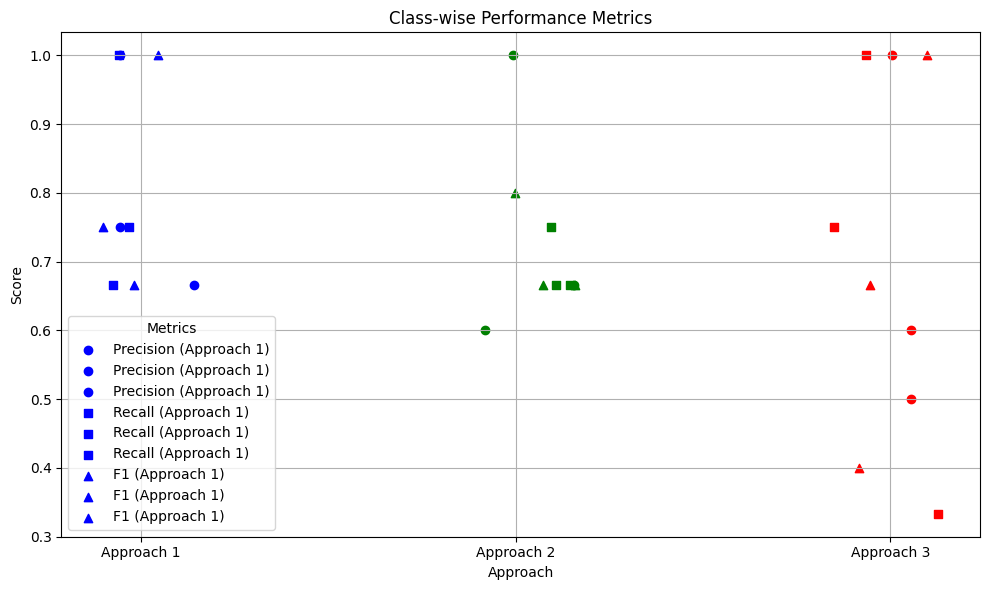

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_wise_performance(metrics_dict):
    symbols = {'precision': 'o', 'recall': 's', 'f1': '^'}  # Define symbols for different metrics
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for different approaches

    fig, ax = plt.subplots(figsize=(10, 6))

    approach_names = list(metrics_dict.keys())
    num_approaches = len(approach_names)

    class_labels = ['0-1s', '1s-10s', '10s-inf']

    for approach_index, (approach_name, (predictions, ground_truth)) in enumerate(metrics_dict.items()):
        if class_labels is None:
            class_labels = np.unique(np.concatenate((predictions, ground_truth)))

        for metric_name, symbol in symbols.items():
            metric_values = calculate_metric(predictions, ground_truth, metric_name)
            for class_label, value in zip(class_labels, metric_values):
                x_val = approach_index + np.random.normal(0, 0.1)
                ax.scatter(x_val, value, marker=symbol, color=colors[approach_index], label=f"{metric_name.capitalize()} ({approach_name})")

    ax.set_xticks(range(num_approaches))
    ax.set_xticklabels(approach_names)
    ax.set_xlabel('Approach')
    ax.set_ylabel('Score')
    ax.set_title('Class-wise Performance Metrics')

    ax.legend(title='Metrics')

    plt.grid(True)
    plt.tight_layout()
    plt.show()

def calculate_metric(predictions, ground_truth, metric_name):
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1_score, _ = precision_recall_fscore_support(ground_truth, predictions, average=None)
    
    if metric_name == 'precision':
        return precision
    elif metric_name == 'recall':
        return recall
    elif metric_name == 'f1':
        return f1_score

# Example usage:
approach_data = {
    'Approach 1': ([0, 1, 2, 0, 2, 1, 1, 0, 1, 2], [0, 1, 2, 0, 1, 1, 2, 0, 1, 2]),
    'Approach 2': ([1, 1, 2, 0, 2, 1, 1, 0, 1, 2], [0, 1, 2, 0, 1, 1, 2, 0, 1, 2]),
    'Approach 3': ([0, 1, 1, 0, 2, 1, 1, 0, 1, 2], [0, 1, 2, 0, 1, 1, 2, 0, 1, 2])
}

plot_class_wise_performance(approach_data)


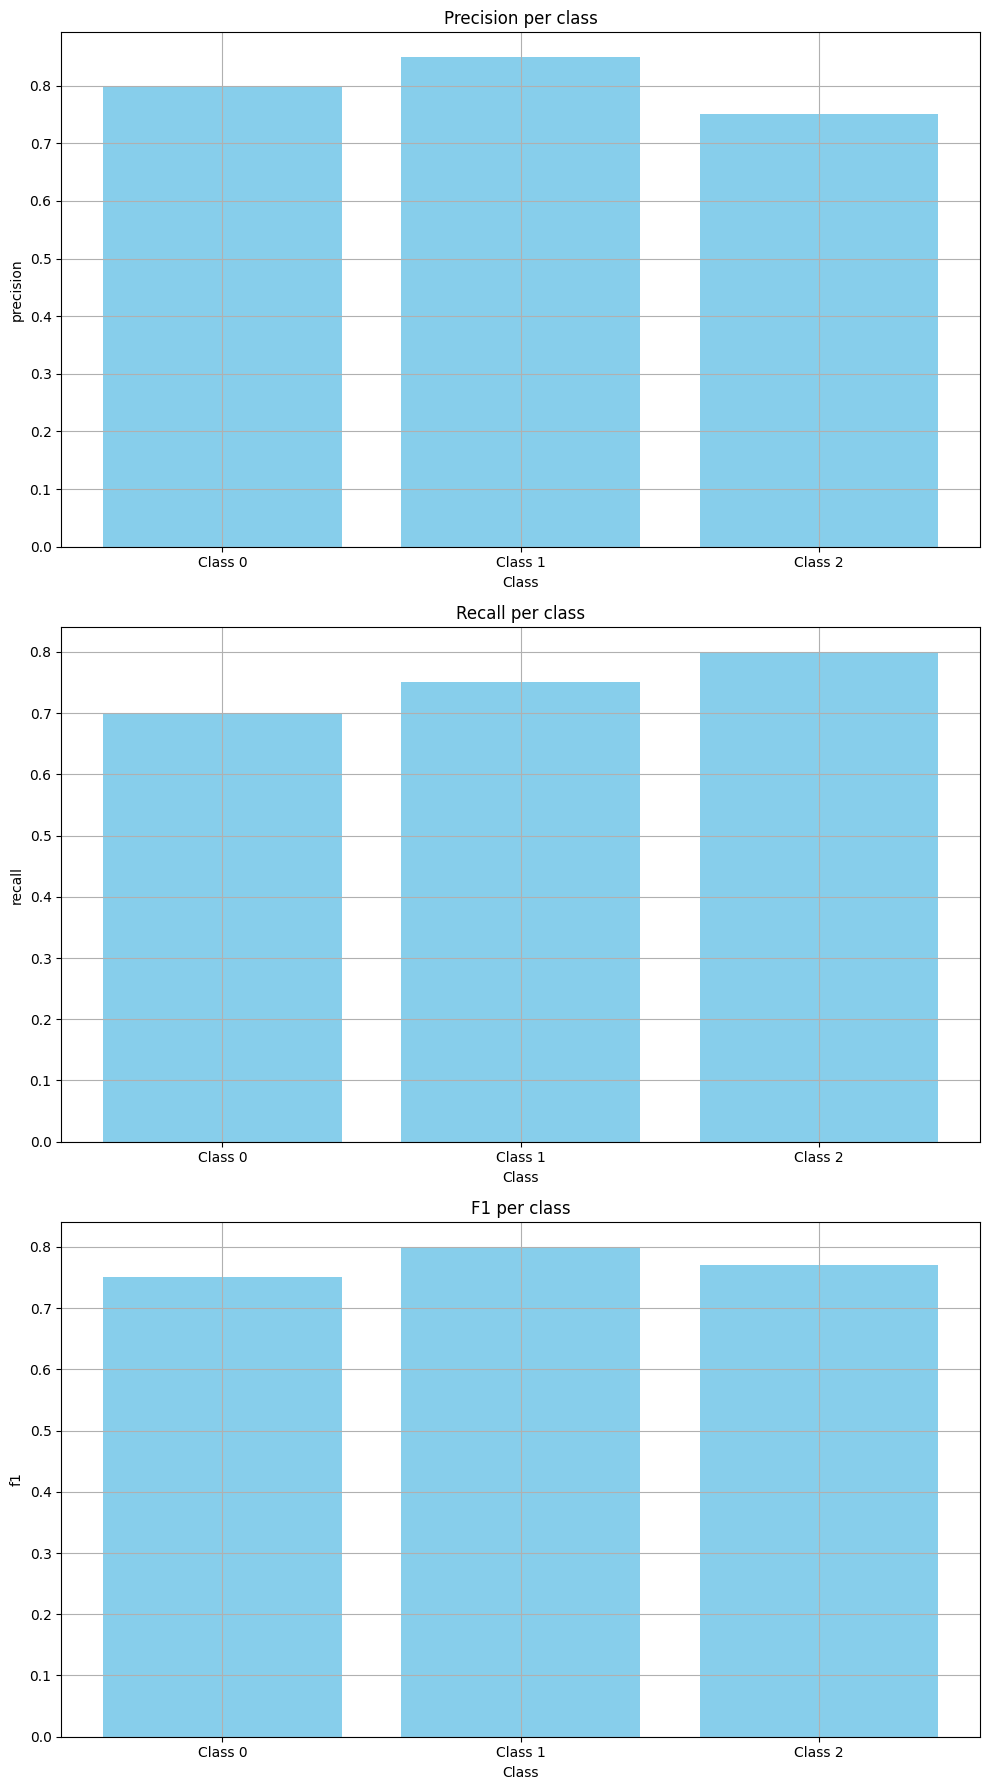

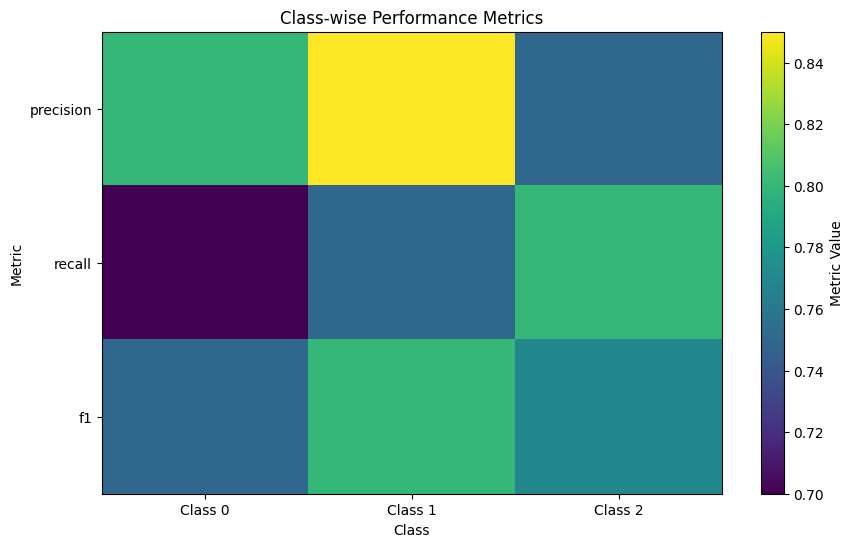

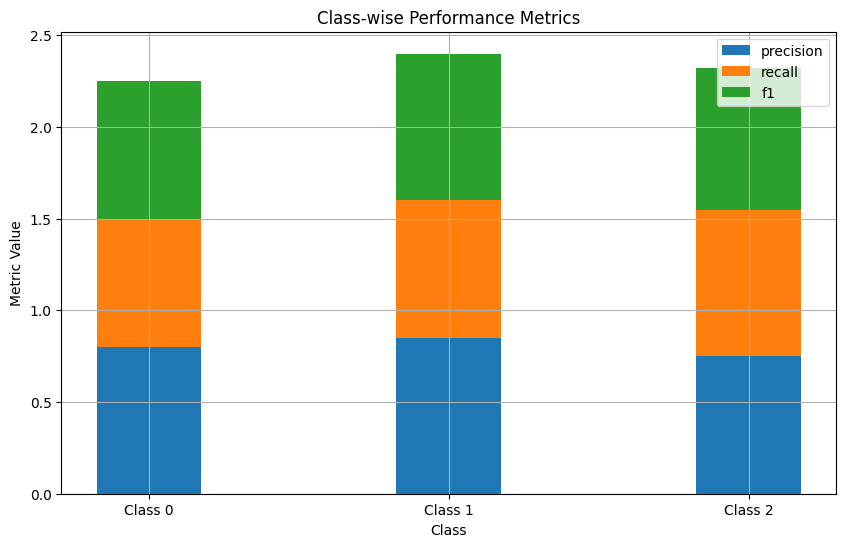

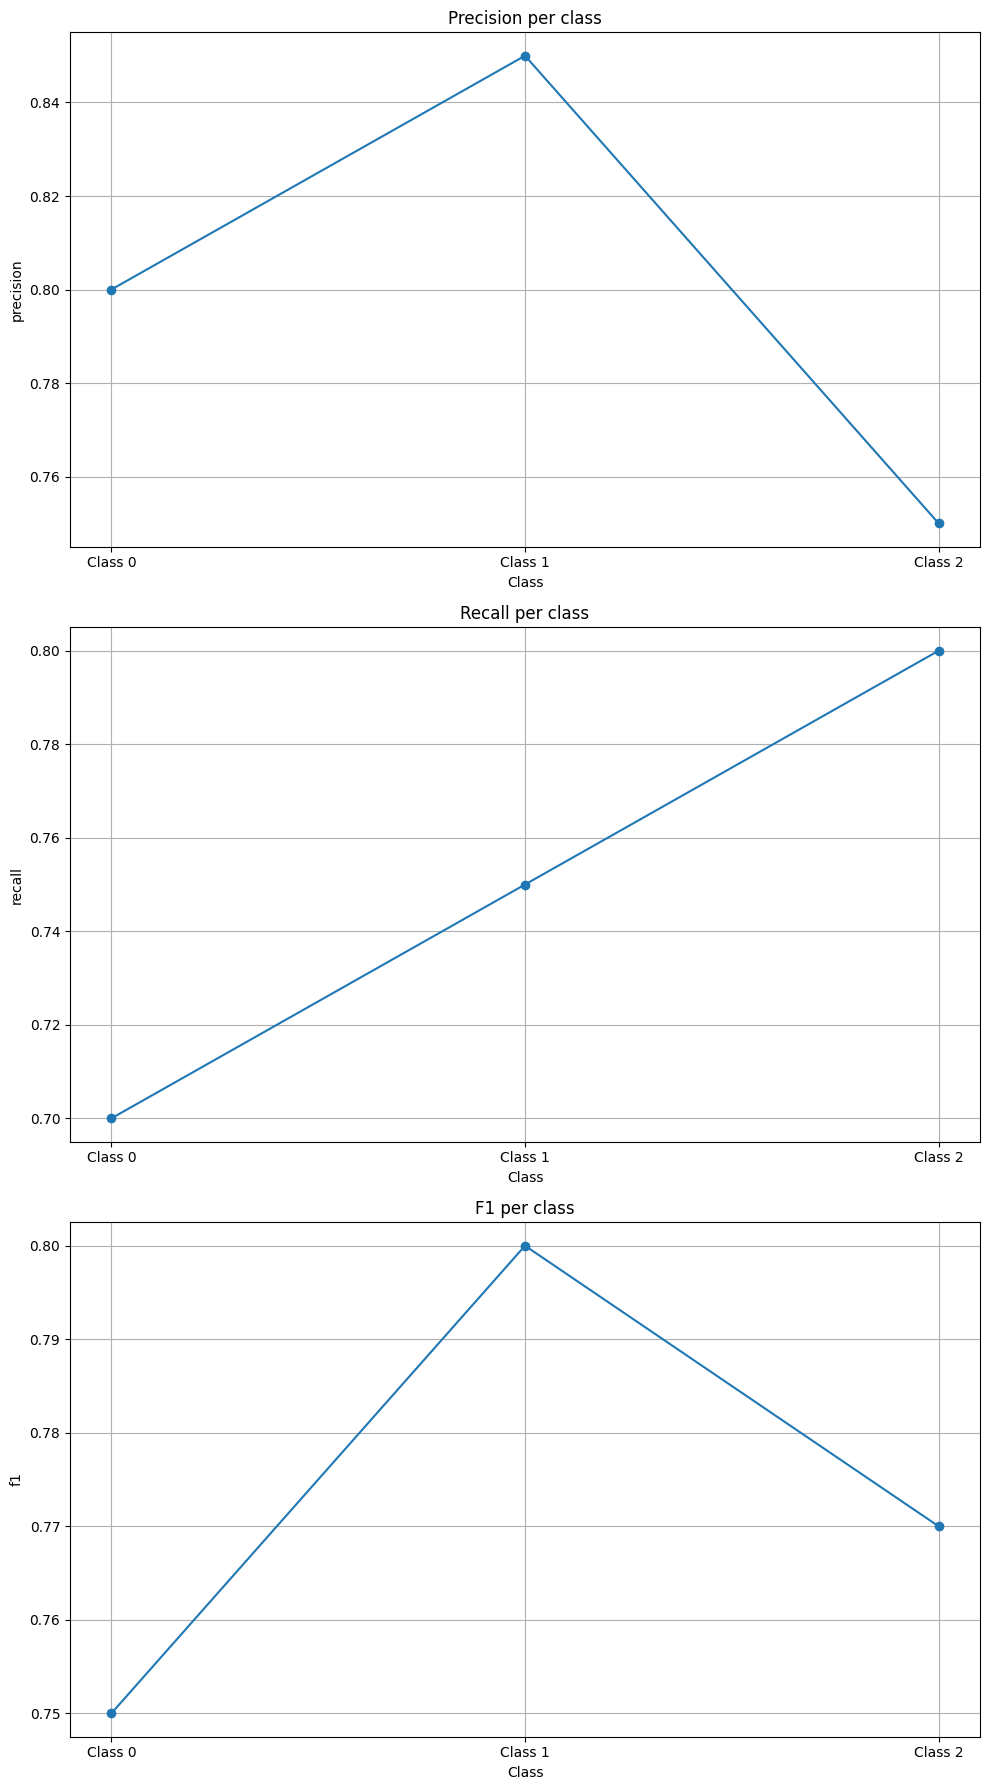

         precision  recall    f1
Class 0       0.80    0.70  0.75
Class 1       0.85    0.75  0.80
Class 2       0.75    0.80  0.77


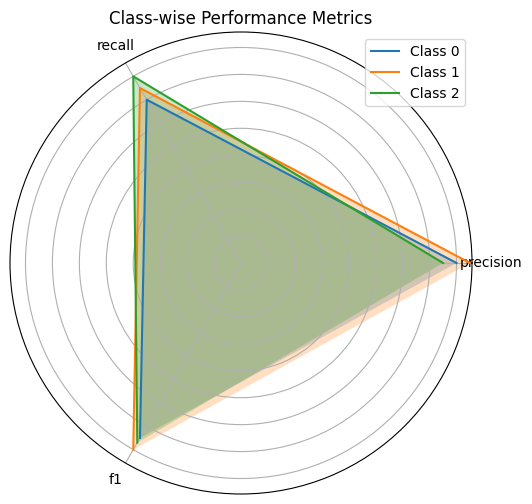

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def bar_plot_classwise_metrics(metrics_dict):
    class_labels = list(metrics_dict.keys())
    metrics_names = list(metrics_dict[class_labels[0]].keys())

    num_classes = len(class_labels)
    num_metrics = len(metrics_names)

    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 6*num_metrics))

    for i, metric_name in enumerate(metrics_names):
        ax = axes[i]
        metric_values = [metrics_dict[class_label][metric_name] for class_label in class_labels]
        ax.bar(class_labels, metric_values, color='skyblue')
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Class')
        ax.set_title(f'{metric_name.capitalize()} per class')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def heatmap_classwise_metrics(metrics_dict):
    class_labels = list(metrics_dict.keys())
    metrics_names = list(metrics_dict[class_labels[0]].keys())

    num_classes = len(class_labels)
    num_metrics = len(metrics_names)

    metrics_matrix = np.zeros((num_metrics, num_classes))

    for i, metric_name in enumerate(metrics_names):
        for j, class_label in enumerate(class_labels):
            metrics_matrix[i, j] = metrics_dict[class_label][metric_name]

    plt.figure(figsize=(10, 6))
    plt.imshow(metrics_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Metric Value')
    plt.xticks(np.arange(num_classes), class_labels)
    plt.yticks(np.arange(num_metrics), metrics_names)
    plt.xlabel('Class')
    plt.ylabel('Metric')
    plt.title('Class-wise Performance Metrics')
    plt.show()

def stacked_bar_plot_classwise_metrics(metrics_dict):
    class_labels = list(metrics_dict.keys())
    metrics_names = list(metrics_dict[class_labels[0]].keys())

    num_classes = len(class_labels)
    num_metrics = len(metrics_names)

    metrics_values = {metric_name: [metrics_dict[class_label][metric_name] for class_label in class_labels] for metric_name in metrics_names}

    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    ind = np.arange(num_classes)

    bottom = np.zeros(num_classes)
    for metric_name in metrics_names:
        metric_values = metrics_values[metric_name]
        ax.bar(ind, metric_values, width, bottom=bottom, label=metric_name)
        bottom += metric_values

    ax.set_ylabel('Metric Value')
    ax.set_xlabel('Class')
    ax.set_title('Class-wise Performance Metrics')
    ax.set_xticks(ind)
    ax.set_xticklabels(class_labels)
    ax.legend()
    plt.grid(True)
    plt.show()

def line_plot_classwise_metrics(metrics_dict):
    class_labels = list(metrics_dict.keys())
    metrics_names = list(metrics_dict[class_labels[0]].keys())

    num_classes = len(class_labels)
    num_metrics = len(metrics_names)

    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 6*num_metrics))

    for i, metric_name in enumerate(metrics_names):
        ax = axes[i]
        metric_values = [metrics_dict[class_label][metric_name] for class_label in class_labels]
        ax.plot(class_labels, metric_values, marker='o', linestyle='-')
        ax.set_ylabel(metric_name)
        ax.set_xlabel('Class')
        ax.set_title(f'{metric_name.capitalize()} per class')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

def table_classwise_metrics(metrics_dict):
    import pandas as pd

    df = pd.DataFrame.from_dict(metrics_dict, orient='index')
    print(df)

def radar_chart_classwise_metrics(metrics_dict):
    class_labels = list(metrics_dict.keys())
    metrics_names = list(metrics_dict[class_labels[0]].keys())

    num_classes = len(class_labels)
    num_metrics = len(metrics_names)

    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))

    for class_label in class_labels:
        values = [metrics_dict[class_label][metric_name] for metric_name in metrics_names]
        ax.plot(angles, values, label=class_label)
        ax.fill(angles, values, alpha=0.25)

    ax.set_yticklabels([])
    ax.set_xticks(angles)
    ax.set_xticklabels(metrics_names)
    ax.set_title('Class-wise Performance Metrics')
    ax.legend()
    plt.show()

# Example usage:
metrics_dict = {
    'Class 0': {'precision': 0.8, 'recall': 0.7, 'f1': 0.75},
    'Class 1': {'precision': 0.85, 'recall': 0.75, 'f1': 0.8},
    'Class 2': {'precision': 0.75, 'recall': 0.8, 'f1': 0.77}
}

bar_plot_classwise_metrics(metrics_dict)
heatmap_classwise_metrics(metrics_dict)
stacked_bar_plot_classwise_metrics(metrics_dict)
line_plot_classwise_metrics(metrics_dict)
table_classwise_metrics(metrics_dict)
radar_chart_classwise_metrics(metrics_dict)


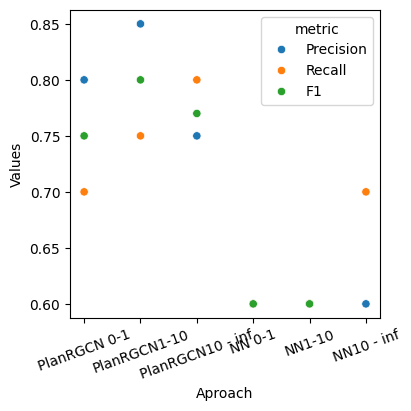

In [79]:
# Example usage:

import seaborn as sns
import matplotlib.pyplot as plt

def scatter_metrics(metrics_dict, fig_size= (4,4), rotation = 20):
    df = pd.DataFrame(metrics_dict)
    fig, ax = plt.subplots(figsize=fig_size)
    sns.scatterplot(data=df, x= "Aproach", y="metric_vals", hue='metric', ax=ax)
    plt.xticks(rotation=rotation)
    ax.set_ylabel("Values")
    
    

metrics_dict = {
    'Aproach': ['PlanRGCN 0-1','PlanRGCN1-10','PlanRGCN10 - inf','PlanRGCN 0-1','PlanRGCN1-10','PlanRGCN10 - inf','PlanRGCN 0-1','PlanRGCN1-10','PlanRGCN10 - inf'],
    'metric_vals' : [0.8,0.85,0.75,0.7,0.75,0.8,0.75,0.8,0.77],
    'metric':['Precision','Precision','Precision','Recall','Recall','Recall','F1','F1','F1'],
    #'Time Intervals' : ['0-1','1-10','10 - inf'],
}
metrics_dict2 = {
    'Aproach': ['NN 0-1','NN1-10','NN10 - inf','NN 0-1','NN1-10','NN10 - inf','NN 0-1','NN1-10','NN10 - inf'],
    'metric_vals' : [0.6,0.6,0.6,0.6,0.6,0.7,0.6,0.6,np.nan],
    'metric':['Precision','Precision','Precision','Recall','Recall','Recall','F1','F1','F1'],
    #'Time Intervals' : ['0-1','1-10','10 - inf'],
}
for k in metrics_dict.keys():
    metrics_dict[k].extend(metrics_dict2[k])
scatter_metrics(metrics_dict)



In [30]:
pd.DataFrame({'col1': [1,2], 'col2':['c','d'],'col3':['a','k']}).melt(id_vars=['col1', 'col3'], value_vars=['col2'])

col1 col3 variable value
0     1    a     col2     c
1     2    k     col2     d

3


[0.0, -1, -1, 0.8]